In [19]:
import pandas as pd
import numpy as np
from numba import jit

In [20]:
us = pd.read_csv('../covid-19-data/us.csv', parse_dates=['date'])

In [21]:
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (16,9)
plt.rcParams['figure.max_open_warning'] = 0

In [22]:
dates = us['date']
us_daily_cases = us['cases'].diff().fillna(0)
us_daily_deaths = us['deaths'].diff().fillna(0)

In [23]:
print('final date:', dates[len(dates)-1])

final date: 2021-10-02 00:00:00


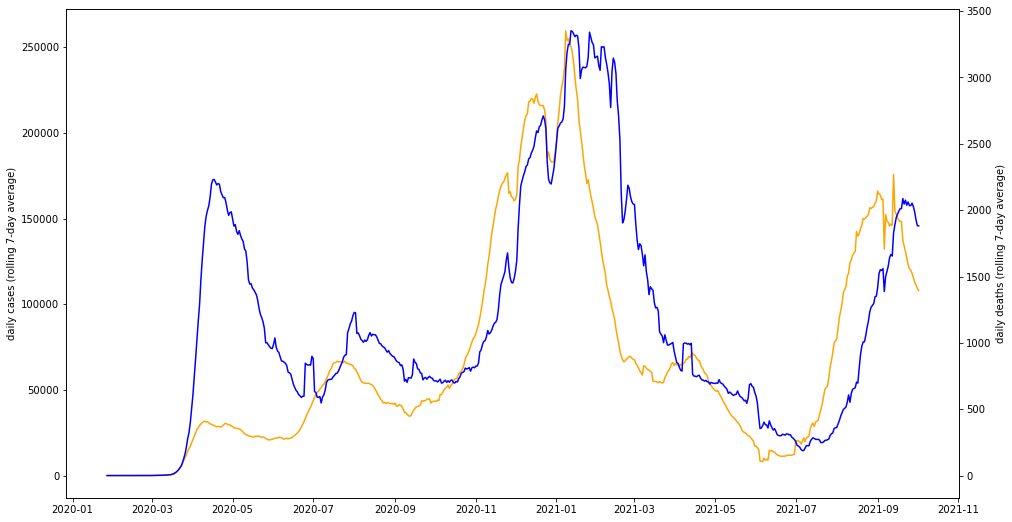

In [24]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.set_ylabel('daily cases (rolling 7-day average)')
ax2.set_ylabel('daily deaths (rolling 7-day average)')

p = ax1.plot(dates,us_daily_cases.rolling(7).mean(),color='orange')
p = ax2.plot(dates,us_daily_deaths.rolling(7).mean(), color='blue')

In [25]:
from math import pi, exp, sqrt, log
from scipy.optimize import curve_fit

In [26]:
@jit(nopython=True)
def gauss(x, mu, sigma):
    # normalized to unit integral
    norm = 1.0/(sigma * sqrt(2*pi))
    arg = -0.5 * ((x - mu)/sigma)**2
    return norm * exp(arg)

In [27]:
@jit(nopython=True)
def normfn(i, norm1, norm1_end, norm2, norm2_end, norm3, norm3_end, norm4):
    if i < norm1_end:
#        return (norm2 - norm1)/norm1_end * i + norm1
        return norm1
    elif i < norm2_end:
        return (norm3 - norm2)/(norm2_end - norm1_end) * (i - norm1_end) + norm2
    elif i < norm3_end:
        return (norm4 - norm3)/(norm3_end - norm2_end) * (i - norm2_end) + norm3
    else:
        return norm4

In [28]:
@jit(nopython=True)
def full_model(newcases, norm1, norm1_end, norm2, norm2_end, norm3, norm3_end, norm4, offset, width):
    num = len(newcases)
    retval = np.zeros(num, np.float64)
    for i in range(0, num):
        for j in range(1, i):
            retval[i] += newcases[j] * normfn(j, norm1, norm1_end, norm2, norm2_end, norm3, norm3_end, norm4) * gauss(i-j, offset, width)
    return retval

In [29]:
norm1_end = 75
norm2_end = 150
norm3_end = 200
sigma = 14
@jit(nopython=True)
def model1(newcases, norm1, norm2, norm3, norm4, offset):
    global norm1_end, norm2_end, norm3_end, sigma
    return full_model(newcases, norm1, norm1_end, norm2, norm2_end, norm3, norm3_end, norm4, offset, sigma)

In [38]:
def us_fit(dates, daily_cases, daily_deaths, plot=True):
    sigma = np.ones(len(daily_cases))
    sigma[0:150] = 10
    dc = np.array(daily_cases)
    dd = np.array(daily_deaths)
    popt, pcov = curve_fit(model1, dc, dd, [10, 0.1, 0.1, 0.002, 18], sigma)
    if plot:
        fig, ax = plt.subplots()
        ax.plot(dates, daily_deaths.rolling(7).mean(), color='blue', label='observed deaths')
        ax.plot(dates, model1(dc, *popt), color='red', label='model deaths')
        ax.axvspan(dates[0], dates[149], alpha=0.2)
    return popt, pcov

In [39]:
len(us_daily_cases)

621

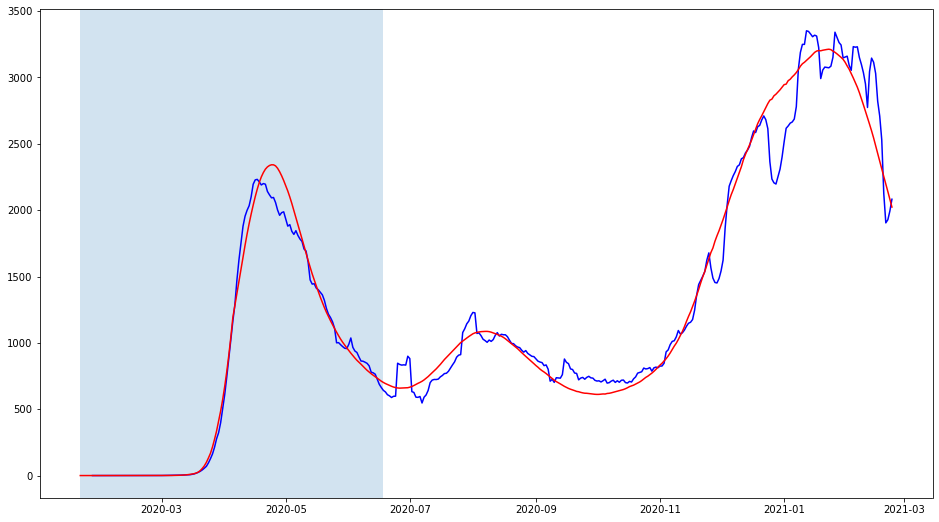

In [40]:
fitend = 400
# d = np.array(dates[:fitend])
# dc = np.array(us_daily_cases[:fitend])
# dd = np.array(us_daily_deaths[:fitend])
popt, pcov = us_fit(dates[:fitend], us_daily_cases[:fitend], us_daily_deaths[:fitend])
#popt, pcov = us_fit(d, dc, dd)

In [41]:
popt

array([2.21692022e-01, 5.22841999e-02, 2.48462809e-02, 1.61406414e-02,
       2.07113233e+01])

In [42]:
perr = np.sqrt(np.diag(pcov))
perr

array([1.26518810e-01, 2.75348126e-02, 3.11489082e-03, 3.92455177e-04,
       1.77482489e+00])

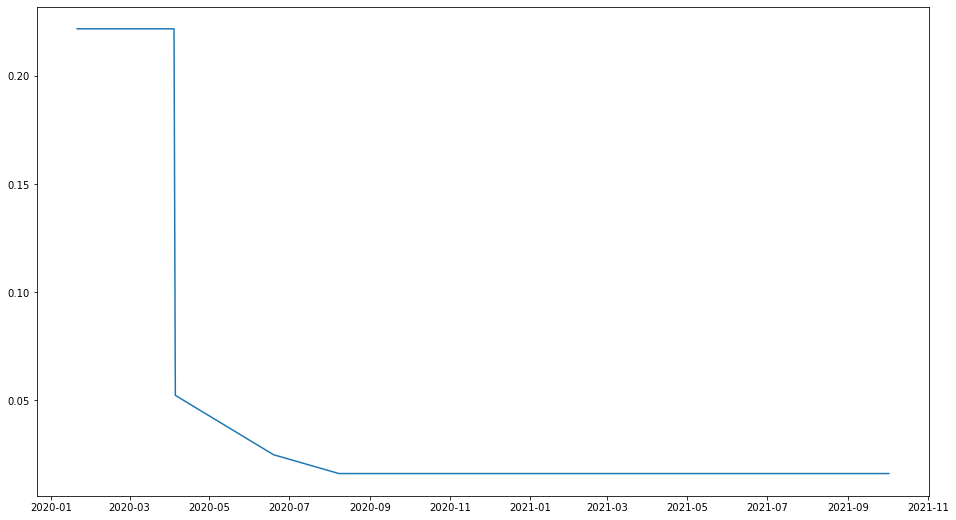

In [43]:
plt.plot(dates, 
    [normfn(i, popt[0], norm1_end, popt[1], norm2_end, popt[2], norm3_end, popt[3]) for i in range(0, len(dates))]);

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
non-precise type pyobject
During: typing of argument at /tmp/ipykernel_559409/1932083497.py (8)

File "../../../../../tmp/ipykernel_559409/1932083497.py", line 8:
<source missing, REPL/exec in use?> 

This error may have been caused by the following argument(s):
- argument 0: Cannot determine Numba type of <class 'pandas.core.series.Series'> 

This error may have been caused by the following argument(s):
- argument 0: Cannot determine Numba type of <class 'pandas.core.series.Series'> 

This error may have been caused by the following argument(s):
- argument 0: Cannot determine Numba type of <class 'pandas.core.series.Series'>


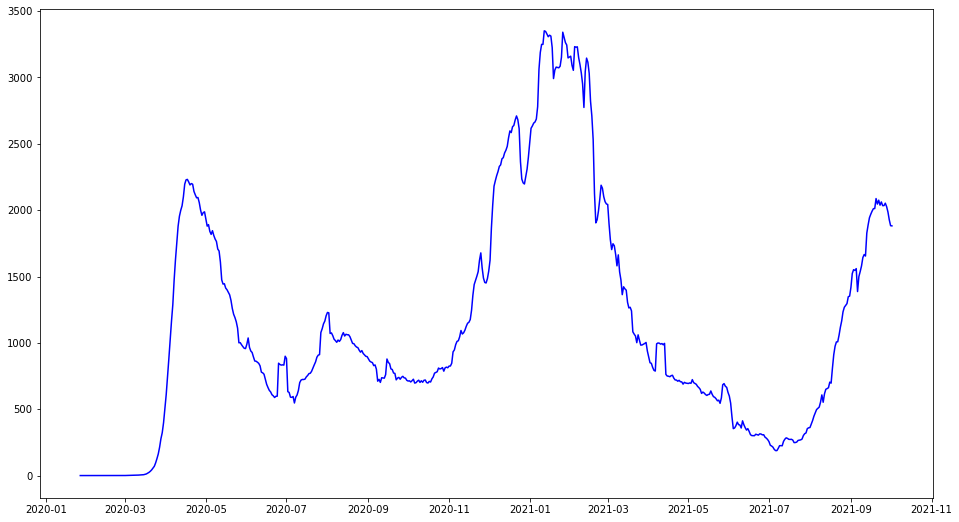

In [44]:
fig, ax = plt.subplots()
ax.plot(dates, us_daily_deaths.rolling(7).mean(), color='blue', label='observed deaths')
ax.plot(dates, model1(us_daily_cases, *popt), color='red', label='model deaths')
ax.axvspan(dates[0], dates[149], alpha=0.2)

